In [1]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
from darts import TimeSeries
from darts.metrics import rmse
from sklearn.metrics import mean_squared_error

torch.manual_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

from darts.models import TFTModel 

In [2]:
!jupytext --set-formats ipynb,py TFT_Covid_2.ipynb
!jupytext --sync TFT_Covid_2.ipynb

[jupytext] Reading TFT_Covid_2.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py"}}'
[jupytext] Updating TFT_Covid_2.ipynb
[jupytext] Updating TFT_Covid_2.py
[jupytext] Reading TFT_Covid_2.ipynb in format ipynb
[jupytext] Loading TFT_Covid_2.py
[jupytext] Updating TFT_Covid_2.ipynb
[jupytext] Updating the timestamp of TFT_Covid_2.py


In [3]:
mm_scaler = StandardScaler()

In [4]:
canada = pd.read_csv('canada.csv')
canada = canada.values[:, 0:3].astype(float)

TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)



In [5]:
canada[:TRAIN_IDX] = mm_scaler.fit_transform(canada[:TRAIN_IDX])
canada[TRAIN_IDX:VAL_IDX] = mm_scaler.transform(canada[TRAIN_IDX:VAL_IDX])
canada_train_val = canada[:VAL_IDX]

time_series = TimeSeries.from_values(canada_train_val)

In [6]:
OUTPUT_STEP = 2  # predict |OUTPUT_STEP| steps as output

parameters = {
    "hidden_continuous_size": [2, 4, 8],
    "lstm_layers": [2, 4],
    "dropout": [0.1, 0.3],   
    "batch_size": [2,4],
    "input_chunk_length": [16,32,64],
    "output_chunk_length": [OUTPUT_STEP],
    "n_epochs": [24],
    "num_attention_heads": [2, 4, 8],   # divisible by number of features
    "add_relative_index": [True]
}

best_model, _, _ = TFTModel.gridsearch(
    parameters = parameters,
    series = time_series[:TRAIN_IDX],
    val_series = time_series[TRAIN_IDX:VAL_IDX],
    metric = rmse,
    n_jobs=16,
    verbose=True)

  0%|          | 0/216 [00:00<?, ?it/s]

[2022-09-23 11:23:07,807] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 2, 'input_chunk_length': 64, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}
[2022-09-23 11:23:07,807] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 2, 'input_chunk_length': 64, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}
2022-09-23 11:23:07 darts.models.forecasting.forecasting_model INFO: Chosen parameters: {'hidden_continuous_size': 8, 'lstm_layers': 2, 'dropout': 0.1, 'batch_size': 2, 'input_chunk_length': 64, 'output_chunk_length': 2, 'n_epochs': 24, 'num_attention_heads': 2, 'add_relative_index': True}


In [8]:
best_model.fit(time_series[:TRAIN_IDX]) 

[2022-09-23 13:44:46,557] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 212 samples.
[2022-09-23 13:44:46,557] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 212 samples.
2022-09-23 13:44:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 212 samples.
[2022-09-23 13:44:46,893] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-09-23 13:44:46,893] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-09-23 13:44:46 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-09-23 13:44:46 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-09-23 13:44:46 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-09-23 13:44:46 pytor

Training: 0it [00:00, ?it/s]

In [9]:
best_model.save_model('tft_train_val.pth.tar')

In [10]:
best_model = TFTModel.load_model('tft_train_val.pth.tar')

In [11]:
predict = best_model.predict(VAL_IDX-TRAIN_IDX)
print(rmse(predict, time_series[TRAIN_IDX:VAL_IDX]))

2022-09-23 13:46:31 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-09-23 13:46:31 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-09-23 13:46:31 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

1.9371964889489082


In [12]:
inversed_predict=mm_scaler.inverse_transform(predict.values())

In [13]:
true_value=mm_scaler.inverse_transform(time_series[TRAIN_IDX:VAL_IDX].values())

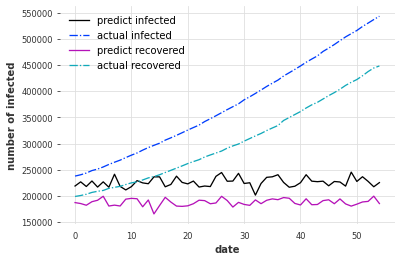

In [14]:
import matplotlib.pyplot as plt

x = range(len(inversed_predict))

plt.plot(x, inversed_predict[:,0], label ='predict infected')
plt.plot(x, true_value[:,0], '-.', label ='actual infected')
plt.plot(x, inversed_predict[:,1], label ='predict recovered')
plt.plot(x, true_value[:,1], '-.', label ='actual recovered')

plt.xlabel("date")
plt.ylabel("number of infected")
plt.legend()
plt.show()

In [15]:
mean_squared_error(inversed_predict[:,0], true_value[:,0])

30204504402.57199